In [83]:
import numpy as np
from math import floor, ceil
from statsmodels.stats.weightstats import ztest, ttest_ind
from scipy.stats import chi2_contingency, fisher_exact, binom_test, hypergeom, norm, expon, t
from scipy import mean, std
from scipy.special import binom
import matplotlib.pyplot as plt
from itertools import chain

In [3]:
p = binom_test(18, 24, 0.5)
print('%.3f' % p)

0.023


In [78]:
def binomial_test(k, n, p):
    delta = abs(n/2.0 - k)
    lo = floor(n/2.0 - delta)
    hi = ceil(n/2.0 + delta)
    p_value = 0
    for i in chain(range(0, lo + 1), range(hi, n + 1)):
        p_value += binom(n, i) * p**i * (1.0 - p)**(n-i)
    return p_value

def binomial_test_elegant(k, n, p):
    delta = abs(n/2.0 - k)
    lo = floor(n/2.0 - delta)
    hi = ceil(n/2.0 + delta)
    return sum([binom(n, i) * p**i * (1.0 - p)**(n-i) for i in chain(range(0, lo + 1), range(hi, n + 1))])

N = 24
H = 18
p = 0.5 # the null hypothesis
print('Scipy p: %.3f' % binomial_test(H, N, p))
print('Our   p: %.3f' % binom_test(H, N, p))

Scipy p: 0.023
Our   p: 0.023


In [57]:
N = 10*1000
H = 5100
p = 0.5 # the null hypothesis
raw_data = H * [1] + (N-H) * [0]
print('Binom test p: %.3f' % binom_test(H, N, p))
print('Z-test p:     %.3f' % ztest(x1=raw_data, value=p)[1])

Binom test p: 0.047
Z-test p:     0.045


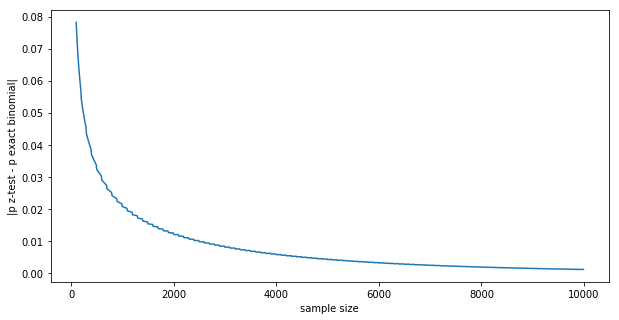

In [133]:
p = 0.5 # the null hypothesis
actual_lift = 0.01
results = []
for N in range(100, 10*1000, 10):
    H = int((p + actual_lift) * N)
    raw_data = H * [1] + (N-H) * [0]
    p_binom = binom_test(H, N, p)
    p_z = ztest(x1=raw_data, value=p)[1]
    p_diff = abs(p_binom - p_z)
    results.append((N, p_diff))

plt.figure(figsize=(10,5))
plt.xlabel('sample size')
plt.ylabel('|p z-test - p exact binomial|')
plt.plot([x[0] for x in results], [x[1] for x in results])
plt.show()

In [79]:
def hypergeom_probability(observations):
    row_marginals = np.sum(observations, axis=1)
    col_marginals = np.sum(observations, axis=0)
    N = np.sum(observations)
    p = 1
    for i in range(len(observations) - 1):
        for j in range(len(observations[i]) - 1):
            p *= hypergeom.pmf(observations[i][j], np.sum(col_marginals[j:]), col_marginals[j], row_marginals[i])
            row_marginals[i] -= observations[i][j]
        col_marginals -= observations[i]
    return p

In [80]:
def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest(funnels, N):
    traffic_split = [x[1] for x in funnels]
    observations = np.zeros([len(funnels), len(funnels[0][0])])
    for _ in range(N):
        which_funnel = choice(traffic_split)
        funnel_outcome = choice(funnels[which_funnel][0])
        observations[which_funnel][funnel_outcome] += 1
    return observations

In [84]:
funnels = [
    [[0.80, 0.10, 0.10], 0.6], # the first vector is the actual outcomes, the second is the traffic split
    [[0.80, 0.10, 0.10], 0.2],
    [[0.80, 0.10, 0.10], 0.2],
]
N = 50*1000

observations = simulate_abtest(funnels, N)
hypergeom_probability(observations)

5.986548312759344e-11

In [128]:
def multi_hypergeom_sample(m, colors):
    remaining = np.cumsum(colors[::-1])[::-1]
    result = np.zeros(len(colors), dtype=np.int)
    for i in range(len(colors)-1):
        if m < 1:
            break
        result[i] = np.random.hypergeometric(colors[i], remaining[i+1], m)
        m -= result[i]
    result[-1] = m
    return result

def sample_once(observations):
    row_marginals = np.sum(observations, axis=1)
    col_marginals = np.sum(observations, axis=0)
    sample = np.copy(observations)
    for i in range(len(row_marginals) - 1):
        sample[i] = multi_hypergeom_sample(row_marginals[i], col_marginals)
        col_marginals -= sample[i]
    sample[len(sample) - 1] = col_marginals
    return sample

def fisher_monte_carlo(observations, num_simulations=10*1000):
    p_obs = hypergeom_probability(observations)
    hits = 0
    for _ in range(num_simulations):
        sample = sample_once(observations)
        p_sample = hypergeom_probability(sample)
        if p_sample <= p_obs:
            hits += 1
    return hits/num_simulations

In [129]:
funnels = [
    [[0.60, 0.40], 0.5], # the first vector is the actual outcomes,
    [[0.60, 0.40], 0.5], # the second is the traffic split
]
N = 100

observations = simulate_abtest(funnels, N)
print(observations)
ch = chi2_contingency(observations, correction=False)
print('chi-squared p = %.3f' % ch[1])
fs = fisher_exact(observations)
print("""fisher's exact p = %.3f""" % fs[1])
fmc = fisher_monte_carlo(observations)
print("""monte carlo p = %.3f""" % fmc)

[[37. 16.]
 [31. 16.]]
chi-squared p = 0.680
fisher's exact p = 0.830
monte carlo p = 0.831


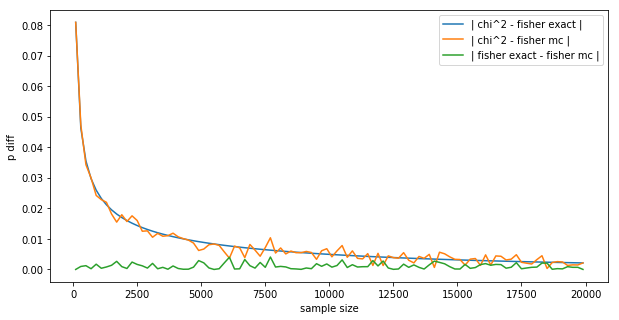

In [132]:
base_conversion = 0.5
traffic_split = 0.5
actual_lift = 0.01

results = []
for N in range(100, 20*1000, 200):
    observations = [
        [int(base_conversion * traffic_split * N), int((1-base_conversion) * traffic_split * N)],
        [int((base_conversion+actual_lift) * (1-traffic_split) * N), int((1-(base_conversion+actual_lift)) * (1-traffic_split) * N)],
    ]
    p_chi2 = chi2_contingency(observations, correction=False)[1]
    p_fish = fisher_exact(observations)[1]
    p_fmc = fisher_monte_carlo(observations, num_simulations=100*1000)
    p_diff_chi2_fish = abs(p_chi2 - p_fish)
    p_diff_chi2_fmc = abs(p_chi2 - p_fmc)
    p_diff_fish_fmc = abs(p_fish - p_fmc)
    results.append((N, p_diff_chi2_fish, p_diff_chi2_fmc, p_diff_fish_fmc))

plt.figure(figsize=(10,5))
plt.xlabel('sample size')
plt.ylabel("""p diff""")
plt.plot([x[0] for x in results], [x[1] for x in results])
plt.plot([x[0] for x in results], [x[2] for x in results])
plt.plot([x[0] for x in results], [x[3] for x in results])
plt.legend(['| chi^2 - fisher exact |', '| chi^2 - fisher mc |', '| fisher exact - fisher mc |'], loc='upper right')
plt.show()

In [127]:
funnels = [
    [[0.60, 0.20, 0.20], 0.6], # the first vector is the actual outcomes, the second is the traffic split
    [[0.60, 0.20, 0.20], 0.2],
    [[0.70, 0.15, 0.15], 0.2],
]
N = 1000

observations = simulate_abtest(funnels, N)
print(observations)
ch = chi2_contingency(observations, correction=False)
print('chi-squared p = %.3f' % ch[1])
mcp = fisher_monte_carlo(observations, num_simulations=100*1000)
print("""monte carlo p = %.3f""" % mcp)

[[368. 113. 112.]
 [126.  45.  55.]
 [125.  26.  30.]]
chi-squared p = 0.076
monte carlo p = 0.078
